In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix
from textwrap import wrap

import pandas as pd
import statsmodels.api as sm 

sns.set(style="darkgrid", palette="Set2", context="paper")
warnings.filterwarnings(action='ignore')

In [181]:
# dont ignore the first line of the csv files. Keep variable as np array

def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

unwrapped_complex_names = read_names("data/complex_names.txt")
unwrapped_monomer_names = read_names("data/protein_names.txt")
unwrapped_cofactor_names = read_names("data/cofactor_names.txt")
unwrapped_element_names = read_names("data/element_ids.txt")
unwrapped_pathway_names = read_names("data/pathway_names.txt")


complex_ids = read_names("data/complex_ids.txt")
monomer_ids = read_names("data/protein_ids.txt")
cofactor_ids = read_names("data/cofactor_ids.txt")
element_ids = read_names("data/element_ids.txt")
pathway_ids = read_names("data/pathway_ids.txt")
aa_ids = read_names("data/amino_acid_ids.txt")

unwrapped_protein_names = np.concatenate([unwrapped_complex_names, unwrapped_monomer_names])
protein_ids = np.concatenate([complex_ids, monomer_ids])

# Reading the matrix CSV files
def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

C = read_matrix("data/C_matrix.csv", sparse=True)
P = read_matrix("data/P_matrix.csv", sparse=True)
E = read_matrix("data/E_matrix.csv", sparse=True)
W = read_matrix("data/W_matrix.csv", sparse=True)
W2 = read_matrix("data/W2_matrix.csv", sparse=True)
W1 = read_matrix("data/W1_matrix.csv", sparse=True)
A = read_matrix("data/A_matrix.csv")
Tree = read_matrix("data/tree_matrix.csv", sparse=True)

total_counts_min = read_matrix("data/counts.csv")
total_counts = read_matrix("data/rich_counts.csv")
total_counts_anaero = read_matrix("data/anaerobic_counts.csv")
total_counts_big = read_matrix("data/rich_counts_big.csv")

monomer_masses = read_matrix("data/monomer_masses.csv").flatten()
monomer_areas = read_matrix("data/monomer_areas.csv").flatten()
complex_areas = read_matrix("data/complex_areas.csv").flatten()
protein_areas = np.concatenate([complex_areas, monomer_areas])

# Validation against 2001 ICP-MS data

<Axes: xlabel='Atoms/cell', ylabel='Count'>

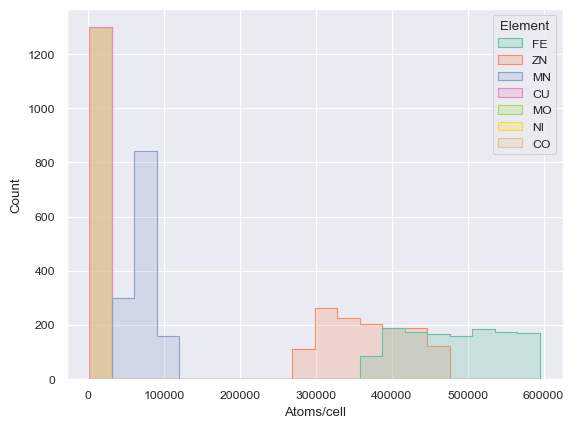

In [182]:
# find the indices of "FE", "ZN", "MN", "CU", "MO", "NI", "CO":
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_timeseries = total_counts @ C @ P @ E[:, element_indices]

# convert to polars dataframe
element_df = pl.DataFrame(element_timeseries, schema=elements)

# melt to long form
element_df = element_df.melt(id_vars=None, value_name="Atoms/cell", variable_name="Element")
sns.histplot(element_df, x="Atoms/cell", hue="Element", element="step")

# plt.xscale("log")

In [183]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO", "V", "CR"]

val_orig_df = pl.read_csv('external_data/distances.csv')

val_orig_df = val_orig_df.with_columns((   (-9* ( 1 - pl.col("Distance") / pl.col("ScaleDist")))  ).alias("Log concentration"))
val_orig_df = val_orig_df.with_columns(   (10**(pl.col("Log concentration"))).alias("Concentration (M)")  )
val_orig_df = val_orig_df.with_columns( (pl.col("Concentration (M)") *  (10**pl.col("ScaleCounts")) ).alias("Atoms/cell"))
val_orig_df

# filter out the elements
val_df = val_orig_df.filter(pl.col("Element").is_in(elements) & pl.col("Cell") == True)

# val_df = val_df.filter(pl.col("Condition") == "Rich")

val_df.write_csv("data/val_df.csv", include_header=True)

## Estimate upper limit of atoms/cell available in media

In [184]:
media_lim_df = val_orig_df.filter(pl.col("Cell") == False).drop(["Error", "Distance", "ScaleDist", "ScaleCounts"])
# media_lim_df = media_lim_df.filter(pl.col("Condition") == "Rich")

# to convert from atoms/cell in media, take the concentration in the media, convert to atoms by mult w avo, then divide by 3e11 cells per L
media_lim_df = media_lim_df.with_columns( (pl.col("Concentration (M)") * 6.022e23 / 3.5e11).alias("Atoms/cell"))

media_lim_df.to_pandas()

,Condition,Below LOD,Cell,Element,Log concentration,Concentration (M),Atoms/cell
0,Minimal,0,0,MO,-7.730374,1.860483e-08,3.201094e+04
1,Minimal,0,0,SE,-7.548822,2.826037e-08,4.862399e+04
2,Minimal,0,0,ZN,-6.903050,1.250115e-07,2.150911e+05
3,Minimal,0,0,CU,-7.208921,6.181290e-08,1.063535e+05
4,Minimal,0,0,NI,-7.707702,1.960187e-08,3.372642e+04
5,Minimal,1,0,CO,-8.342515,4.544486e-09,7.819112e+03
6,Minimal,1,0,FE,-6.460629,3.462353e-07,5.957225e+05
7,Minimal,0,0,MN,-7.685031,2.065235e-08,3.553384e+04
8,Minimal,0,0,CR,-6.687467,2.053679e-07,3.533501e+05
9,Minimal,0,0,V,-7.707504,1.961085e-08,3.374187e+04


## Import EZ rich composition

In [185]:
ez_df = pl.read_csv('external_data/ez_media_concentrations.csv')

# convert µM to molar
ez_df = ez_df.with_columns( (ez_df["Concentration (µM)"] * 1e-6).alias("Concentration (M)")  )

# convert to atoms/cell assuming 8.0 * 10^8 cells per L
ez_df = ez_df.with_columns( (ez_df["Concentration (M)"] * 6.022e23 / 2e11).alias("Atoms/cell")  )

# Set Zn to 0 since it's unreliable due to contamination
ez_df = ez_df.with_columns(pl.when(pl.col("Element") == "ZN").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))

ez_df

Condition,Element,Concentration (raw),Concentration (µM),Concentration (M),Atoms/cell
str,str,str,f64,f64,f64
"""Minimal""","""FE""","""10 µM""",10.0,0.00001,3.011e7
"""Minimal""","""MN""","""80 nM""",0.08,8.0000e-8,240880.0
"""Minimal""","""CO""","""30.0 nM""",0.03,3.0000e-8,90330.0
"""Minimal""","""ZN""","""10 nM""",0.01,1.0000e-8,-500000.0
"""Minimal""","""CU""","""10 nM""",0.01,1.0000e-8,30110.0
"""Minimal""","""MO""","""3 nM""",0.003,3.0000e-9,9033.0
"""Minimal""","""NI""","""0 nM""",0.0,0.0,0.0
"""Rich""","""FE""","""10 µM""",10.0,0.00001,3.011e7
"""Rich""","""MN""","""80 nM""",0.08,8.0000e-8,240880.0


## Final rich plot

In [186]:
rich_exp_caption = "Experiment, LB rich media"
rich_sim_caption = "Simulation, EZ rich media"
minimal_exp_caption = "Experiment, M9 minimal media"
minimal_sim_caption = "Simulation, MOPS minimal media"

figure_height = 3

In [187]:
# copy ez_df to have 0 at the minimal condition
ez_df_copy = ez_df.clone().filter(pl.col("Element").is_in(elements))
ez_df_copy = ez_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))
ez_df_copy = ez_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(pl.lit(rich_exp_caption)).otherwise(pl.lit(rich_sim_caption)).alias("Type"))

# zero values above 800000
ez_df_copy = ez_df_copy.with_columns(pl.when(pl.col("Atoms/cell") > 800000).then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))

In [188]:
# temporarily modify media_lim_df to have 0 at the minimal condition
media_lim_df_copy = media_lim_df.clone().filter(pl.col("Element").is_in(elements))
media_lim_df_copy = media_lim_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))
media_lim_df_copy = media_lim_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(pl.lit(rich_sim_caption)).otherwise(pl.lit(rich_exp_caption)).alias("Type"))
# zero values above 800000
media_lim_df_copy = media_lim_df_copy.with_columns(pl.when(pl.col("Atoms/cell") > 800000).then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))

media_lim_df_copy.to_pandas()

,Condition,Below LOD,Cell,Element,Log concentration,Concentration (M),Atoms/cell,Type
0,Minimal,0,0,MO,-7.730374,1.860483e-08,-500000.000000,"Simulation, EZ rich media"
1,Minimal,0,0,ZN,-6.903050,1.250115e-07,-500000.000000,"Simulation, EZ rich media"
2,Minimal,0,0,CU,-7.208921,6.181290e-08,-500000.000000,"Simulation, EZ rich media"
3,Minimal,0,0,NI,-7.707702,1.960187e-08,-500000.000000,"Simulation, EZ rich media"
4,Minimal,1,0,CO,-8.342515,4.544486e-09,-500000.000000,"Simulation, EZ rich media"
5,Minimal,1,0,FE,-6.460629,3.462353e-07,-500000.000000,"Simulation, EZ rich media"
6,Minimal,0,0,MN,-7.685031,2.065235e-08,-500000.000000,"Simulation, EZ rich media"
7,Minimal,0,0,CR,-6.687467,2.053679e-07,-500000.000000,"Simulation, EZ rich media"
8,Minimal,0,0,V,-7.707504,1.961085e-08,-500000.000000,"Simulation, EZ rich media"
9,Rich,0,0,MO,-6.522642,3.001637e-07,516453.080545,"Experiment, LB rich media"


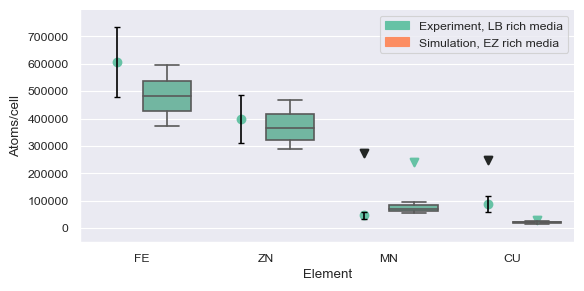

In [189]:
# find the indices of "FE", "ZN", "MN", "CU", "MO", "NI", "CO":
elements = ["FE", "ZN", "MN", "CU"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_timeseries = total_counts @ C @ P @ E[:, element_indices]

# convert to polars dataframe
element_df = pl.DataFrame(element_timeseries, schema=elements)

# melt to long form
element_df = element_df.melt(id_vars=None, value_name="Atoms/cell", variable_name="Element")


# temporarily modify val_df to have 0 at the minimal condition
val_df_copy = val_df.clone()
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))




# add artificial column to separate validation from element_df
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(pl.lit(rich_sim_caption)).otherwise(pl.lit(rich_exp_caption)).alias("Type"))


g = sns.catplot(data=val_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type",  kind="point", aspect=2, order=elements, join=False, 
                dodge=.4, hue_order=[rich_exp_caption, rich_sim_caption], legend=False, height=figure_height)



element_df = element_df.with_columns(Condition = pl.lit("Minimal"))
element_df = element_df.with_columns(Type = pl.lit(rich_sim_caption))
element_df = pl.concat([element_df, pl.DataFrame({"Element": "FE", "Atoms/cell": -500000, "Condition": "Rich", "Type": rich_exp_caption})])  
element_df

# stupid workaround to plot errorbars
for ax in g.axes[0]:
    for path in ax.collections:
        points = path.get_offsets()
    all_x_values = [path.get_offsets()[:, 0] for path in ax.collections]
    all_y_values = [path.get_offsets()[:, 1] for path in ax.collections]
    
x_coords = list(all_x_values[0]) # list(all_x_values[0]) + 
y_coords = list(all_y_values[0]) # list(all_y_values[0]) +
error_vals = [val_df.filter((pl.col("Condition") == "Rich") & (pl.col("Element") == element))[0,"Error"] for element in elements]

# add errorbar plot at these coords
plt.errorbar(x = x_coords, y = y_coords, yerr=error_vals, fmt='none', c= 'black', capsize = 2)

# g.map_dataframe(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
#             hue="Condition")

g.map(sns.pointplot, data=media_lim_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[rich_exp_caption, rich_sim_caption], join=False, dodge=.4, label="Media limit", order=elements, markers=['v', None])

ax = g.map(sns.pointplot, data=ez_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[rich_exp_caption, rich_sim_caption], join=False, dodge=.4, label="Media limit", order=elements, markers=[None, 'v'])

ax = g.map(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[rich_exp_caption, rich_sim_caption], order=elements)

plt.ylim(-50000, None)


plt.legend(handles=[mpatches.Patch(color=sns.color_palette("Set2")[0], label=rich_exp_caption),
                    mpatches.Patch(color=sns.color_palette("Set2")[1], label=rich_sim_caption)])

# change the color used to the first color of the set2 palette
# ax.get_legend().get_texts()[0].set_color(sns.color_palette("Set2")[0])

# sns.move_legend(
#     g, "lower center",
#     bbox_to_anchor=(.67, .75), ncol=1, title="Condition", frameon=True,
# )

# plt.yscale("log")

(-1000.0, 20000.0)

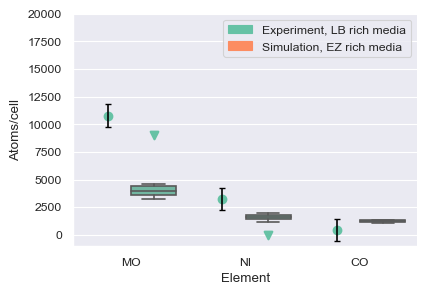

In [190]:


# find the indices of "FE", "ZN", "MN", "CU", "MO", "NI", "CO":
elements = ["MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_timeseries = total_counts @ C @ P @ E[:, element_indices]

# convert to polars dataframe
element_df = pl.DataFrame(element_timeseries, schema=elements)

# melt to long form
element_df = element_df.melt(id_vars=None, value_name="Atoms/cell", variable_name="Element")


# temporarily modify val_df to have 0 at the minimal condition
val_df_copy = val_df.clone()
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))




# add artificial column to separate validation from element_df
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(pl.lit(rich_sim_caption)).otherwise(pl.lit(rich_exp_caption)).alias("Type"))


g = sns.catplot(data=val_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type",  kind="point", aspect=1.5, order=elements, join=False, dodge=.4, 
                hue_order=[rich_exp_caption, rich_sim_caption], legend=False, height=figure_height)



element_df = element_df.with_columns(Condition = pl.lit("Minimal"))
element_df = element_df.with_columns(Type = pl.lit(rich_sim_caption))
element_df = pl.concat([element_df, pl.DataFrame({"Element": "FE", "Atoms/cell": -500000, "Condition": "Rich", "Type": rich_exp_caption})])  
element_df

# stupid workaround to plot errorbars
for ax in g.axes[0]:
    for path in ax.collections:
        points = path.get_offsets()
    all_x_values = [path.get_offsets()[:, 0] for path in ax.collections]
    all_y_values = [path.get_offsets()[:, 1] for path in ax.collections]
    
x_coords = list(all_x_values[0]) # list(all_x_values[0]) + 
y_coords = list(all_y_values[0]) # list(all_y_values[0]) +
error_vals = [val_df.filter((pl.col("Condition") == "Rich") & (pl.col("Element") == element))[0,"Error"] for element in elements]

# add errorbar plot at these coords
plt.errorbar(x = x_coords, y = y_coords, yerr=error_vals, fmt='none', c= 'black', capsize = 2)

# g.map_dataframe(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
#             hue="Condition")

g.map(sns.pointplot, data=media_lim_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[rich_exp_caption, rich_sim_caption], join=False, dodge=.4, label="Media limit", order=elements, markers=['v', None])

g.map(sns.pointplot, data=ez_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[rich_exp_caption, rich_sim_caption], join=False, dodge=.4, label="Media limit", order=elements, markers=[None, 'v'])

g.map(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[rich_exp_caption, rich_sim_caption], order=elements)

# modify legend
plt.legend(handles=[mpatches.Patch(color=sns.color_palette("Set2")[0], label=rich_exp_caption),
                    mpatches.Patch(color=sns.color_palette("Set2")[1], label=rich_sim_caption)])

plt.ylim(-1000, 20000)

# plt.yscale("log")

# Add biologically unnecessary trace elements 

In [191]:
# find the indices of "FE", "ZN", "MN", "CU", "MO", "NI", "CO":
elements = ["V", "CR"]
estimated_counts = np.zeros([2,1], dtype=np.int64)
# convert to polars dataframe
element_df = pl.DataFrame(estimated_counts, schema=elements)

# melt to long form
element_df = element_df.melt(id_vars=None, value_name="Atoms/cell", variable_name="Element")
element_df

Element,Atoms/cell
str,i64
"""V""",0
"""CR""",0


(-1000.0, 20000.0)

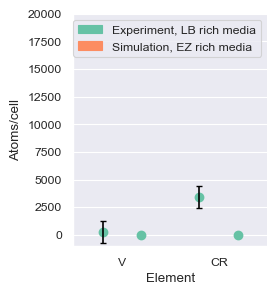

In [192]:

# temporarily modify val_df to have 0 at the minimal condition
val_df_copy = val_df.clone()
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))




# add artificial column to separate validation from element_df
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Minimal").then(pl.lit(rich_sim_caption)).otherwise(pl.lit(rich_exp_caption)).alias("Type"))


g = sns.catplot(data=val_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type",  kind="point", aspect=1, order=elements, join=False, dodge=.4, 
                hue_order=[rich_exp_caption, rich_sim_caption], legend=False, height=figure_height)



element_df = element_df.with_columns(Condition = pl.lit("Minimal"))
element_df = element_df.with_columns(Type = pl.lit(rich_sim_caption))
element_df = pl.concat([element_df, pl.DataFrame({"Element": "FE", "Atoms/cell": -500000, "Condition": "Rich", "Type": rich_exp_caption})])  
element_df

# stupid workaround to plot errorbars
for ax in g.axes[0]:
    for path in ax.collections:
        points = path.get_offsets()
    all_x_values = [path.get_offsets()[:, 0] for path in ax.collections]
    all_y_values = [path.get_offsets()[:, 1] for path in ax.collections]
    
x_coords = list(all_x_values[0]) # list(all_x_values[0]) + 
y_coords = list(all_y_values[0]) # list(all_y_values[0]) +
error_vals = [val_df.filter((pl.col("Condition") == "Rich") & (pl.col("Element") == element))[0,"Error"] for element in elements]

# add errorbar plot at these coords
plt.errorbar(x = x_coords, y = y_coords, yerr=error_vals, fmt='none', c= 'black', capsize = 2)

# g.map_dataframe(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
#             hue="Condition")

g.map(sns.pointplot, data=media_lim_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[rich_exp_caption, rich_sim_caption], join=False, dodge=.4, label="Media limit", order=elements, markers=['v', None])

g.map(sns.pointplot, data=ez_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[rich_exp_caption, rich_sim_caption], join=False, dodge=.4, label="Media limit", order=elements, markers=[None, 'v'])

g.map(sns.pointplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[rich_exp_caption, rich_sim_caption], order=elements, join=False, dodge=.4,)

# modify legend
plt.legend(handles=[mpatches.Patch(color=sns.color_palette("Set2")[0], label=rich_exp_caption),
                    mpatches.Patch(color=sns.color_palette("Set2")[1], label=rich_sim_caption)])

plt.ylim(-1000, 20000)

# plt.yscale("log")

## Final minimal plot

In [193]:
element_df

Element,Atoms/cell,Condition,Type
str,i64,str,str
"""V""",0,"""Minimal""","""Simulation, EZ…"
"""CR""",0,"""Minimal""","""Simulation, EZ…"
"""FE""",-500000,"""Rich""","""Experiment, LB…"


In [194]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]

# copy ez_df to have 0 at the minimal condition
ez_df_copy = ez_df.clone().filter(pl.col("Element").is_in(elements))
ez_df_copy = ez_df_copy.with_columns(pl.when(pl.col("Condition") == "Rich").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))
ez_df_copy = ez_df_copy.with_columns(pl.when(pl.col("Condition") == "Rich").then(pl.lit(minimal_exp_caption)).otherwise(pl.lit(minimal_sim_caption)).alias("Type"))

# zero values above 800000
ez_df_copy = ez_df_copy.with_columns(pl.when(pl.col("Atoms/cell") > 800000).then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))

In [195]:
# temporarily modify media_lim_df to have 0 at the minimal condition
media_lim_df_copy = media_lim_df.clone().filter(pl.col("Element").is_in(elements))
media_lim_df_copy = media_lim_df_copy.with_columns(pl.when(pl.col("Condition") == "Rich").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))
media_lim_df_copy = media_lim_df_copy.with_columns(pl.when(pl.col("Condition") == "Rich").then(pl.lit(minimal_sim_caption)).otherwise(pl.lit(minimal_exp_caption)).alias("Type"))
# zero values above 800000
media_lim_df_copy = media_lim_df_copy.with_columns(pl.when(pl.col("Atoms/cell") > 500000).then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))

media_lim_df_copy.to_pandas()

,Condition,Below LOD,Cell,Element,Log concentration,Concentration (M),Atoms/cell,Type
0,Minimal,0,0,MO,-7.730374,1.860483e-08,32010.938103,"Experiment, M9 minimal media"
1,Minimal,0,0,ZN,-6.903050,1.250115e-07,215091.142940,"Experiment, M9 minimal media"
2,Minimal,0,0,CU,-7.208921,6.181290e-08,106353.506190,"Experiment, M9 minimal media"
3,Minimal,0,0,NI,-7.707702,1.960187e-08,33726.423494,"Experiment, M9 minimal media"
4,Minimal,1,0,CO,-8.342515,4.544486e-09,7819.112138,"Experiment, M9 minimal media"
5,Minimal,1,0,FE,-6.460629,3.462353e-07,-500000.000000,"Experiment, M9 minimal media"
6,Minimal,0,0,MN,-7.685031,2.065235e-08,35533.842778,"Experiment, M9 minimal media"
7,Rich,0,0,MO,-6.522642,3.001637e-07,-500000.000000,"Simulation, MOPS minimal media"
8,Rich,0,0,ZN,-4.931786,1.170077e-05,-500000.000000,"Simulation, MOPS minimal media"
9,Rich,0,0,CU,-6.840925,1.442363e-07,-500000.000000,"Simulation, MOPS minimal media"


(-25000.0, 408777.1)

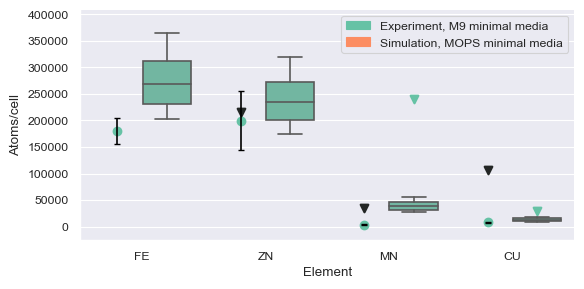

In [196]:
# find the indices of "FE", "ZN", "MN", "CU", "MO", "NI", "CO":
elements = ["FE", "ZN", "MN", "CU"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_timeseries = total_counts_min @ C @ P @ E[:, element_indices]

# convert to polars dataframe
element_df = pl.DataFrame(element_timeseries, schema=elements)

# melt to long form
element_df = element_df.melt(id_vars=None, value_name="Atoms/cell", variable_name="Element")


# temporarily modify val_df to have 0 at the minimal condition
val_df_copy = val_df.clone()
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Rich").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))

# add artificial column to separate validation from element_df
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Rich").then(pl.lit(minimal_sim_caption)).otherwise(pl.lit(minimal_exp_caption)).alias("Type"))


g = sns.catplot(data=val_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type",  kind="point", aspect=2, order=elements, join=False, dodge=.4, height=figure_height, legend=False)

element_df = element_df.with_columns(Condition = pl.lit("Rich"))
element_df = element_df.with_columns(Type = pl.lit(minimal_sim_caption))
element_df = pl.concat([element_df, pl.DataFrame({"Element": "FE", "Atoms/cell": -500000, "Condition": "Minimal", "Type": minimal_exp_caption})])  
element_df

# stupid workaround to plot errorbars
for ax in g.axes[0]:
    for path in ax.collections:
        points = path.get_offsets()
    all_x_values = [path.get_offsets()[:, 0] for path in ax.collections]
    all_y_values = [path.get_offsets()[:, 1] for path in ax.collections]
    
x_coords = list(all_x_values[0]) # list(all_x_values[0]) + 
y_coords = list(all_y_values[0]) # list(all_y_values[0]) +
error_vals = [val_df.filter((pl.col("Condition") == "Minimal") & (pl.col("Element") == element))[0,"Error"] for element in elements]

# add errorbar plot at these coords
plt.errorbar(x = x_coords, y = y_coords, yerr=error_vals, fmt='none', c= 'black', capsize = 2)

# g.map_dataframe(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
#             hue="Condition")

g.map(sns.pointplot, data=media_lim_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[minimal_exp_caption, minimal_sim_caption], join=False, dodge=.4, label="Media limit", order=elements, markers=['v', None])

g.map(sns.pointplot, data=ez_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[minimal_exp_caption, minimal_sim_caption], join=False, dodge=.4, label="Media limit", order=elements, markers=[None, 'v'])

g.map(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[minimal_exp_caption, minimal_sim_caption])

# modify legend
plt.legend(handles=[mpatches.Patch(color=sns.color_palette("Set2")[0], label=minimal_exp_caption),
                    mpatches.Patch(color=sns.color_palette("Set2")[1], label=minimal_sim_caption)])

# set lower ylim to 0
plt.ylim(-25000, None)

# plt.yscale("log")

(-500.0, 10000.0)

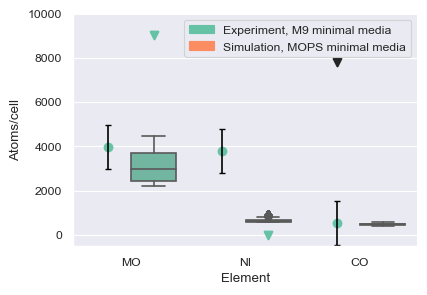

In [197]:
# find the indices of "FE", "ZN", "MN", "CU", "MO", "NI", "CO":
elements = ["MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_timeseries = total_counts_min @ C @ P @ E[:, element_indices]

# convert to polars dataframe
element_df = pl.DataFrame(element_timeseries, schema=elements)

# melt to long form
element_df = element_df.melt(id_vars=None, value_name="Atoms/cell", variable_name="Element")


# temporarily modify val_df to have 0 at the minimal condition
val_df_copy = val_df.clone()
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Rich").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))

# add artificial column to separate validation from element_df
val_df_copy = val_df_copy.with_columns(pl.when(pl.col("Condition") == "Rich").then(pl.lit(minimal_sim_caption)).otherwise(pl.lit(minimal_exp_caption)).alias("Type"))


g = sns.catplot(data=val_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type",  kind="point", aspect=1.5, order=elements, join=False, dodge=.4, height=figure_height, legend=False)

element_df = element_df.with_columns(Condition = pl.lit("Rich"))
element_df = element_df.with_columns(Type = pl.lit(minimal_sim_caption))
element_df = pl.concat([element_df, pl.DataFrame({"Element": "MO", "Atoms/cell": -500000, "Condition": "Minimal", "Type": minimal_exp_caption})])  
element_df

# stupid workaround to plot errorbars
for ax in g.axes[0]:
    for path in ax.collections:
        points = path.get_offsets()
    all_x_values = [path.get_offsets()[:, 0] for path in ax.collections]
    all_y_values = [path.get_offsets()[:, 1] for path in ax.collections]
    
x_coords = list(all_x_values[0]) # list(all_x_values[0]) + 
y_coords = list(all_y_values[0]) # list(all_y_values[0]) +
error_vals = [val_df.filter((pl.col("Condition") == "Minimal") & (pl.col("Element") == element))[0,"Error"] for element in elements]

# add errorbar plot at these coords
plt.errorbar(x = x_coords, y = y_coords, yerr=error_vals, fmt='none', c= 'black', capsize = 2)

# g.map_dataframe(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
#             hue="Condition")

g.map(sns.pointplot, data=media_lim_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[minimal_exp_caption, minimal_sim_caption], join=False, dodge=.4, label="Media limit", order=elements, markers=['v', None])

g.map(sns.pointplot, data=ez_df_copy.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[minimal_exp_caption, minimal_sim_caption], join=False, dodge=.4, label="Media limit", order=elements, markers=[None, 'v'])

g.map(sns.boxplot, data=element_df.to_pandas(), x="Element", y="Atoms/cell", 
            hue="Type", hue_order=[minimal_exp_caption, minimal_sim_caption])

# modify legend
plt.legend(handles=[mpatches.Patch(color=sns.color_palette("Set2")[0], label=minimal_exp_caption),
                    mpatches.Patch(color=sns.color_palette("Set2")[1], label=minimal_sim_caption)])

# set lower ylim to 0
plt.ylim(-500, 10000)

# plt.yscale("log")

# Single-cell data

In [198]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

sc_df = pl.read_csv('external_data/single_cell_fe.csv')

# remove the first row
# sc_df = sc_df.filter((pl.col("Bin") > 16) & (pl.col("Bin") < 60))

# create 1d list of all bins with comprehension
bins = sc_df["Bin"].to_numpy()
counts = sc_df["Count"].to_numpy()

# create a list with bin value repeated counts times
real_hist_data = np.repeat(bins, counts)

In [199]:
# compute the timeseries for the elements
big_element_timeseries = total_counts_big[:, 1:-1] @ C @ P @ E[:, element_indices]

# convert to polars dataframe
big_element_df = pl.DataFrame(big_element_timeseries, schema=elements)

# add Timestep and Cell index from total_counts_big 
big_element_df = big_element_df.with_columns(pl.DataFrame(total_counts_big[:, [0, -1]], schema=["Timestep", "Cell index"]))
big_element_df

# Groupby cell index, then add the max timestep for each cell
max_timestep = big_element_df.group_by("Cell index").agg(pl.col("Timestep").max().alias("Max timestep"))

# merge with original
big_element_df = big_element_df.join(max_timestep, on="Cell index")

# calculate cell density correction factor with 2 ^((Max timestep - Timestep)/Max timestep)
big_element_df = big_element_df.with_columns( (2 ** ((big_element_df["Max timestep"] - big_element_df["Timestep"]) 
                                                     / big_element_df["Max timestep"])).alias("Density correction"))

# remove all cols except element, cell index and density correction
big_element_df = big_element_df.drop(["Timestep", "Max timestep"])

# multiply the atoms/cell by the density correction
big_element_df = big_element_df.melt(id_vars=["Cell index", "Density correction"], value_name="Atoms/cell", variable_name="Element")

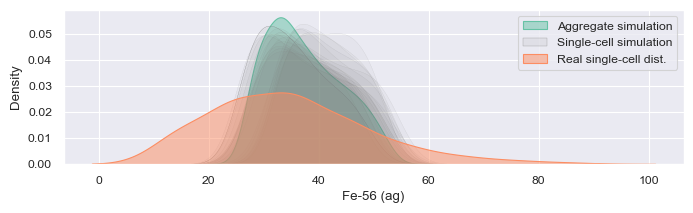

In [200]:
# filter FE 
big_fe_df = big_element_df.filter(pl.col("Element") == "FE")

# convert atoms/cell to float
big_fe_df = big_fe_df.with_columns( (big_fe_df["Atoms/cell"] * 55.85 * 10**18 * 0.92 / (6.023*10**23)).alias("Fe-56 (ag)"))

# create fig
plt.figure(figsize=(8, 2))

# create a weighted KDE plot 
sns.kdeplot(data=big_fe_df.to_pandas(), x="Fe-56 (ag)", weights="Density correction", fill=True, bw_adjust=2, label="Aggregate simulation", alpha=0.5)
# sns.histplot(data=big_fe_df.to_pandas(), x="Fe-56 (ag)", weights="Density correction",stat="density", binwidth=10, alpha=0.5, label="Aggregate sim")

# plot every cell from 0 to 18 with low alpha and gray color
for i in range(0, 18):
    if i == 1:
        sns.kdeplot(data=big_fe_df.filter(pl.col("Cell index") == i).to_pandas(), x="Fe-56 (ag)", 
                weights="Density correction", fill=True, bw_adjust=2, alpha=0.1, color="gray", linewidth=0.2, label="Single-cell simulation")
    else:
        sns.kdeplot(data=big_fe_df.filter(pl.col("Cell index") == i).to_pandas(), x="Fe-56 (ag)", 
                # weights="Density correction", 
                fill=True, bw_adjust=2, alpha=0.05, color="gray", linewidth=0.05)

# sns.kdeplot(data=big_fe_df.filter(pl.col("Cell index") == 10).to_pandas(), x="Fe-56 (ag)", 
#             weights="Density correction", fill=True, bw_adjust=2, label="Random cell 10")
# sns.kdeplot(data=big_fe_df.filter(pl.col("Cell index") == 3).to_pandas(), x="Fe-56 (ag)", 
#             weights="Density correction", fill=True, bw_adjust=2, label="Random cell 3")

# plot histogram data in sc_df, as lineplot with fill
sns.kdeplot(data=real_hist_data, fill=True, bw_adjust=1.3, label="Real single-cell dist.", alpha=0.5)
# sns.histplot(real_hist_data, element="step", stat="density", binwidth=10, alpha=0.3, label="Real single-cell dist.", binrange=(10, 90))

plt.legend()

# Figure 2, general insights

## Resource comparison

In [201]:
elements = ["FE", "ZN"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

aa = ["TRP", "GLY"]
aa_indices = [np.where(aa_ids == aa)[0][0] for aa in aa]

In [202]:
median_count = csr_matrix(np.diag(np.median(total_counts_min, axis=0)))

pe_counts = median_count @ C @ P @ E[:, element_indices]
paa_counts = (median_count @ C @ A[:, aa_indices])
pm_mass = median_count @ C * monomer_masses
resources = csr_matrix(np.stack([pe_counts[:, 0].toarray().flatten(), pe_counts[:, 1].toarray().flatten(), 
                                 paa_counts[:, 0].flatten(), paa_counts[:, 1].flatten(), pm_mass], axis=0))

# need to assign here to pathways
Pw = (C @ W @ W2) / (C @ W @ W2).sum(axis=1)

# multiply resources by Pw
Rp = resources @ Pw

In [203]:
wrapped_names = ["\n".join(wrap(text, 14)) for text in unwrapped_pathway_names]

# put in one array and convert to dataframe
resource_df = pl.DataFrame(Rp.toarray(), schema=elements + aa + ["Protein mass"])

# add protein ID column
resource_df = resource_df.with_columns(pl.DataFrame(wrapped_names, schema=["Pathway"]))

# melt df 
resource_df = resource_df.melt(value_name="Value", variable_name="Resource", id_vars="Pathway")

# groupby resource and get the sum
sum_df = resource_df.group_by("Resource").agg(pl.sum("Value").alias("Total"))

# join with resource_df to get the percentage
resource_df = resource_df.join(sum_df, on="Resource")
resource_df = resource_df.with_columns( (resource_df["Value"] / resource_df["Total"]).alias("Fraction"))

# drop zero value rows
resource_df = resource_df.filter(pl.col("Value") > 0)

# groupby pathway and get the sum of fraction
sum_f_df = resource_df.group_by("Pathway").agg(pl.sum("Fraction").alias("Sum of resource fractions"))

# join with resource_df to get the percentage
resource_df = resource_df.join(sum_f_df, on="Pathway")

# drop rows with Sum of resource fractions < 0.1
resource_df_f = resource_df.filter(pl.col("Sum of resource fractions") > 0.15)


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Translation'),
  Text(1, 0, 'Uncategorized'),
  Text(2, 0, 'Cofactor,\nCarrier, and\nVitamin\nBiosynthesis'),
  Text(3, 0, 'Amino Acid\nBiosynthesis'),
  Text(4, 0, 'Electron\nTransfer\nChains'),
  Text(5, 0, 'Regulation of\ntranscription'),
  Text(6, 0, 'TCA cycle'),
  Text(7, 0, 'Nucleoside and\nNucleotide\nBiosynthesis')])

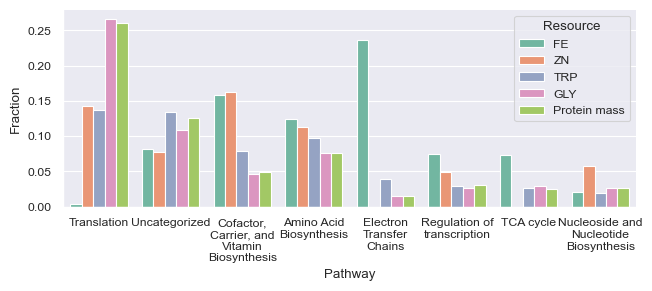

In [204]:
pw_order = resource_df_f.filter(pl.col("Resource") == "FE").sort("Sum of resource fractions", descending=True).select("Pathway").to_series().to_list()

sns.catplot(x="Pathway", y="Fraction", hue="Resource", data=resource_df.to_pandas(), kind="bar", aspect=2.2, height=3, order=pw_order, legend_out=False)

# rotate labels
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'G6763-MONOMER'),
  Text(1, 0, 'CPLX0-7747'),
  Text(2, 0, 'EG10308-MONOMER'),
  Text(3, 0, 'CPLX0-7938'),
  Text(4, 0, 'CPLX0-8585'),
  Text(5, 0, 'CPLX0-7521'),
  Text(6, 0, 'G7087-MONOMER'),
  Text(7, 0, 'G7128-MONOMER'),
  Text(8, 0, 'EG10321-MONOMER'),
  Text(9, 0, 'CPLX0-8103'),
  Text(10, 0, 'CPLX0-7452'),
  Text(11, 0, 'EG11967-MONOMER'),
  Text(12, 0, 'CPLX0-8102'),
  Text(13, 0, 'EG11545-MONOMER'),
  Text(14, 0, 'MONOMER0-4539'),
  Text(15, 0, 'CPLX0-2441'),
  Text(16, 0, 'FLGI-FLAGELLAR-P-RING'),
  Text(17, 0, 'CPLX0-8104'),
  Text(18, 0, 'EG10841-MONOMER'),
  Text(19, 0, 'CPLX0-7956')])

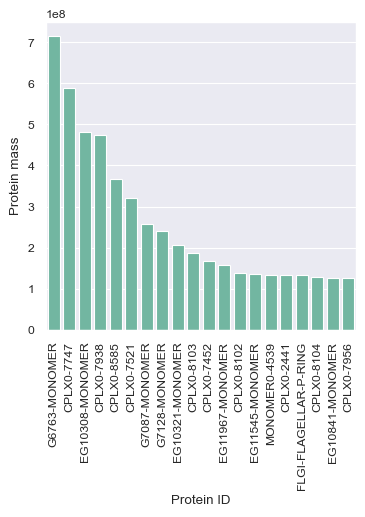

In [205]:
uncategorized_vec = (csr_matrix(np.diag(resources[-1, :].toarray().flatten())) @ Pw)[:, list(pathway_ids).index("Uncategorized (II)")]


# convert to dataframe
uncategorized_df = pl.DataFrame(uncategorized_vec.toarray(), schema=["Protein mass"])

# add protein ID column
uncategorized_df = uncategorized_df.with_columns(pl.DataFrame(protein_ids, schema=["Protein ID"]))

# sort and get top 20, then plot
uncategorized_df = uncategorized_df.sort("Protein mass", descending=True).head(20)

plt.figure(figsize=(4, 4))
sns.barplot(data=uncategorized_df.to_pandas(), x="Protein ID", y="Protein mass", color=sns.color_palette("Set2")[0])

plt.xticks(rotation=90)

## Fe/Zn generalist vs specialist

In [206]:
median_count = csr_matrix(np.diag(np.median(total_counts_min, axis=0)))

ep_counts = median_count @ C @ P @ E[:, element_indices]

# convert to dataframe
ep_df = pl.DataFrame(ep_counts.toarray(), schema=elements)

# add protein_ids as a column
ep_df = ep_df.with_columns(pl.DataFrame(protein_ids, schema=["Protein"]))

# melt to long form
ep_df = ep_df.melt(id_vars="Protein", value_name="Metal atoms allocated to protein", variable_name="Element")

# remove all rows with 0 atoms/cell
ep_df = ep_df.filter(pl.col("Metal atoms allocated to protein") > 0)

# Get the sum per element
sum_df = ep_df.group_by("Element").agg(pl.sum("Metal atoms allocated to protein").alias("Total atoms"))

# Join with ep_df to get the percentage
ep_df = ep_df.join(sum_df, on="Element")

# calculate the percentage
ep_df = ep_df.with_columns( (ep_df["Metal atoms allocated to protein"] / ep_df["Total atoms"]).alias("Fraction of metal"))

# sort by element, then by fraction of metal
ep_df = ep_df.sort(["Element", "Fraction of metal"], descending=[False, True])

# get the index per row
ep_df = ep_df.with_columns(pl.DataFrame(np.arange(1, ep_df.shape[0]+1), schema=["Index"]))

# groupby element and get minimum index
min_index = ep_df.group_by("Element").agg(pl.min("Index").alias("Min index"))

# join with ep_df, then subtract min index from index
ep_df = ep_df.join(min_index, on="Element")
ep_df = ep_df.with_columns( (ep_df["Index"] - ep_df["Min index"] + 1).alias("Rank"))
ep_df = ep_df.drop(["Min index", "Index"])

# Create cumulative sum of fraction of metal
cumsum_col = ep_df.select(pl.col('Fraction of metal').cumsum().over('Element'))

# add column to ep_df
ep_df = ep_df.with_columns(cumsum_col)

# rename fraction of metal to cumulative fraction of metal
ep_df = ep_df.rename({"Fraction of metal": "Cumulative fraction of metal"})

ep_df

Protein,Element,Metal atoms allocated to protein,Total atoms,Cumulative fraction of metal,Rank
str,str,f64,f64,f64,i64
"""NADH-DHI-CPLX""","""FE""",22624.0,268867.0,0.084146,1
"""3-ISOPROPYLMAL…","""FE""",15304.0,268867.0,0.141066,2
"""GLUTAMATESYN-C…","""FE""",13496.0,268867.0,0.191262,3
"""ACONITATEDEHYD…","""FE""",10568.0,268867.0,0.230568,4
"""CPLX0-7797""","""FE""",10464.0,268867.0,0.269486,5
"""SDH-FE-S""","""FE""",9828.0,268867.0,0.30604,6
"""THIC-MONOMER""","""FE""",9360.0,268867.0,0.340853,7
"""G7949-MONOMER""","""FE""",7152.0,268867.0,0.367453,8
"""CYT-O-UBIOX-CP…","""FE""",6986.0,268867.0,0.393436,9


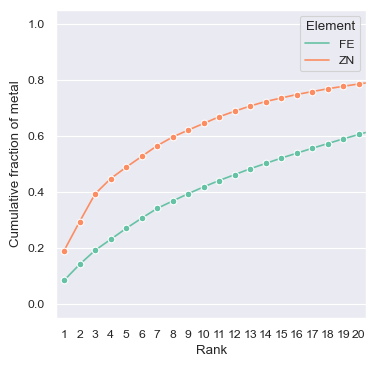

In [207]:
# plot fraction of metal against rank
plt.figure(figsize=(4, 4))
g = sns.lineplot(data=ep_df.to_pandas(), x="Rank", y="Cumulative fraction of metal", hue="Element", marker="o")
plt.xlim(0.5, 20.5)
plt.ylim(-0.05, 1.05)
plt.xticks(np.arange(1, 21, 1))
g.xaxis.grid(False)

<Axes: xlabel='Metal atoms allocated to protein', ylabel='Proportion'>

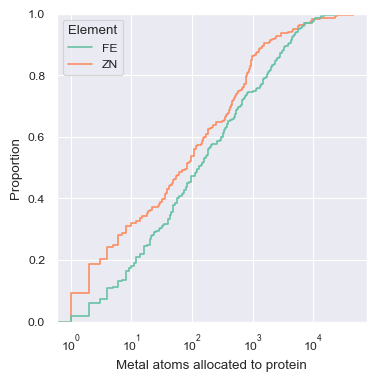

In [208]:
plt.figure(figsize=(4, 4))
sns.ecdfplot(data=ep_df.to_pandas(), x="Metal atoms allocated to protein", hue="Element", complementary=False, log_scale=True)

## Cell iron is mostly in iron-sulfur clusters

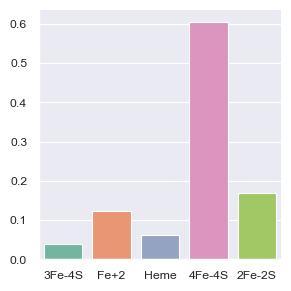

In [209]:
plot_names = {'3FE-4S': '3Fe-4S', 'FE+2': 'Fe+2', 'Heme-b': 'Heme', 'CPD-7': '4Fe-4S', 'CPD-6':'2Fe-2S'}

elements = ["FE"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# find cofactors that use iron
cofactor_iron_stoich = E[:, element_indices].toarray().flatten()

# cofactor names
cofactor_names = np.array(cofactor_ids)[cofactor_iron_stoich > 0]
cofactor_names = [plot_names.get(name, name) for name in cofactor_names]

# compute the distribution across forms of iron
median_count = csr_matrix(np.median(total_counts_min, axis=0))
ep_counts = np.multiply((median_count @ C @ P)[:, cofactor_iron_stoich>0].toarray(), cofactor_iron_stoich[cofactor_iron_stoich>0])

# divide by sum
ep_counts = ep_counts / ep_counts.sum(axis=1)

# create dataframe
ep_df = pl.DataFrame(ep_counts, schema=cofactor_names)

# make plot
sns.catplot(data=ep_df.to_pandas(), kind="bar", aspect=1, height=3)

## # Compare different real bulk data sets

# Li et al data

In [210]:
li = pl.read_csv("external_data/Li_2014_profiling.csv")
li


Gene,MOPS complete,MOPS minimal,MOPS complete without methionine
str,i64,i64,i64
"""aaeA""",62,5,21
"""aaeB""",16,2,0
"""aaeR""",203,79,141
"""aaeX""",28,5,11
"""aas""",188,80,162
"""aat""",151,111,123
"""abgA""",9,12,8
"""abgB""",5,9,0
"""abgR""",27,26,19


In [211]:

name_df = pl.read_csv("external_data/ecocyc_name_conversion.txt", separator="\t")
name_df

Proteins,Genes,Accession-1 of Gene,Common-Name
str,str,str,str
"""LYSU-CPLX""","""EG10553""","""b4129""","""lysU"""
"""EG11817-MONOME…","""EG11817""","""b2744""","""umpG"""
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB"""
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI"""
"""G6991-MONOMER""","""G6991""","""b1807""","""tsaB"""
"""ADENODEAMIN-MO…","""EG10030""","""b1623""","""add"""
"""EG10875-MONOME…","""EG10875""","""b3310""","""rplN"""
"""G7586-MONOMER""","""G7586""","""b3047""","""yqiH"""
"""G6284-MONOMER""","""G6284""","""b0515""","""allE"""


In [212]:
li_df = li.join(name_df, left_on="Gene", right_on="Common-Name")
li_df

Gene,MOPS complete,MOPS minimal,MOPS complete without methionine,Proteins,Genes,Accession-1 of Gene
str,i64,i64,i64,str,str,str
"""lysU""",1644,315,768,"""LYSU-CPLX""","""EG10553""","""b4129"""
"""cobB""",827,572,666,"""MONOMER0-4534""","""G6577""","""b1120"""
"""fdoI""",221,16,13,"""FDOI-MONOMER""","""EG11856""","""b3892"""
"""add""",724,265,548,"""ADENODEAMIN-MO…","""EG10030""","""b1623"""
"""rplN""",118153,18836,79079,"""EG10875-MONOME…","""EG10875""","""b3310"""
"""yqiH""",4,4,0,"""G7586-MONOMER""","""G7586""","""b3047"""
"""sgrT""",0,0,0,"""MONOMER0-2842""","""G0-10617""","""b4662"""
"""yqeH""",14,5,0,"""G7466-MONOMER""","""G7466""","""b2846"""
"""yibG""",8,5,0,"""EG11763-MONOME…","""EG11763""","""b3596"""


In [213]:
# make a list where for each name in monomer_ids,  the corresponding counts in MOPS minimal from li is inserted
# if not found, insert 0
li_counts = [li_df.filter(pl.col("Proteins") == protein)[0, "MOPS complete"] if len(li_df.filter(pl.col("Proteins") == protein)) > 0 else 0 for protein in monomer_ids]
li_counts_min = [li_df.filter(pl.col("Proteins") == protein)[0, "MOPS minimal"] if len(li_df.filter(pl.col("Proteins") == protein)) > 0 else 0 for protein in monomer_ids]
li_counts_met = [li_df.filter(pl.col("Proteins") == protein)[0, "MOPS complete without methionine"] if len(li_df.filter(pl.col("Proteins") == protein)) > 0 else 0 for protein in monomer_ids]


li_counts = np.array(li_counts).flatten().astype(int)
li_counts_min = np.array(li_counts_min).flatten().astype(int)
li_counts_met = np.array(li_counts_met).flatten().astype(int)

# save to csv 
np.savetxt('data/li_counts.csv', np.array(li_counts, dtype=np.int64), delimiter=',', fmt='%i')
np.savetxt('data/li_counts_min.csv', np.array(li_counts_min, dtype=np.int64), delimiter=',', fmt='%i')
np.savetxt('data/li_counts_met.csv', np.array(li_counts_min, dtype=np.int64), delimiter=',', fmt='%i')

In [214]:
elements = ["FE", "ZN"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

M = (P @ E[:, element_indices]).toarray()

# make a new array. For each column of M, multiply it elementwise by the li_counts vector
for i in range(M.shape[1]):
    M[:, i] = np.multiply(M[:, i], li_counts_met)

# create polars dataframe. cols are elements, rows are protein_ids
M_df = pl.DataFrame(M, schema=elements)

# add protein_ids as a column
M_df = M_df.with_columns(pl.DataFrame(monomer_ids, schema=["Protein ID"]))

# melt to long form
M_df = M_df.melt(id_vars="Protein ID", value_name="Atoms/cell", variable_name="Element")

In [215]:
# plot top 20 proteins using iron
top_20_proteins = M_df.filter(pl.col("Element") == "ZN").sort(by="Atoms/cell", descending=True).head(20)

top_20_proteins

Protein ID,Element,Atoms/cell
str,str,i64
"""HOMOCYSMET-MON…","""ZN""",282818
"""G7061-MONOMER""","""ZN""",100140
"""ZNUA-MONOMER""","""ZN""",57733
"""FRUCTBISALD-CL…","""ZN""",30954
"""RPOC-MONOMER""","""ZN""",20760
"""EG10230-MONOME…","""ZN""",17469
"""EG10889-MONOME…","""ZN""",16272
"""EG10240-MONOME…","""ZN""",9902
"""EG10695-MONOME…","""ZN""",8822


In [216]:
M_df.filter((pl.col("Element") == "ZN") & (pl.col("Atoms/cell") > 0))

Protein ID,Element,Atoms/cell
str,str,i64
"""ACETYLORNDEACE…","""ZN""",628
"""ADENODEAMIN-MO…","""ZN""",548
"""ADHC-MONOMER""","""ZN""",3116
"""ADHP-MONOMER""","""ZN""",42
"""ALAS-MONOMER""","""ZN""",5773
"""ALKAPHOSPHA-MO…","""ZN""",348
"""AROB-MONOMER""","""ZN""",516
"""ASPCARBREG-MON…","""ZN""",463
"""CARBODEHYDRAT-…","""ZN""",18


## Create comparison plot between methionine and dropout

In [217]:
cofactor_ids

array(['PYRIDOXAL_PHOSPHATE', 'LIPOIC-ACID', '3FE-4S', 'ZN+2',
       'THIAMINE-PYROPHOSPHATE', 'FMN', 'Any+2', 'NA+', 'MG+2', 'FE+2',
       'MN+2', 'Heme-b', 'CPD-8123', 'BIOTIN', 'CA+2', 'COB-I-ALAMIN',
       'CPD-7', 'CPD-6', 'CPD-3', 'L-SELENOCYSTEINE', 'NI+2', 'K+',
       'CO+2', 'CU+2', 'FAD'], dtype='<U22')

In [281]:
cofactors = ["ZN+2"]
cofactor_indices = [np.where(cofactor_ids == cofactor)[0][0] for cofactor in cofactors]

# get indices of Zn-containing proteins
zn_protein_mask = P[:, cofactor_indices].toarray().flatten() > 0 

# get all ribosome proteins
ribosome_id = ['CPLX0-3964']
ribosome_indices = [np.where(protein_ids == protein)[0][0] for protein in ribosome_id]
ribosome_protein_mask = C[ribosome_indices, :].toarray().flatten() > 0

# nonstandard ribosomal protein
nonstandard_ribosome_id = ['G6167-MONOMER','MONOMER0-2656', ]
nonstandard_ribosome_indices = [np.where(monomer_ids == protein)[0][0] for protein in nonstandard_ribosome_id]
nonstandard_ribosome_protein_mask = np.zeros(len(monomer_ids), dtype=bool)
nonstandard_ribosome_protein_mask[nonstandard_ribosome_indices] = True

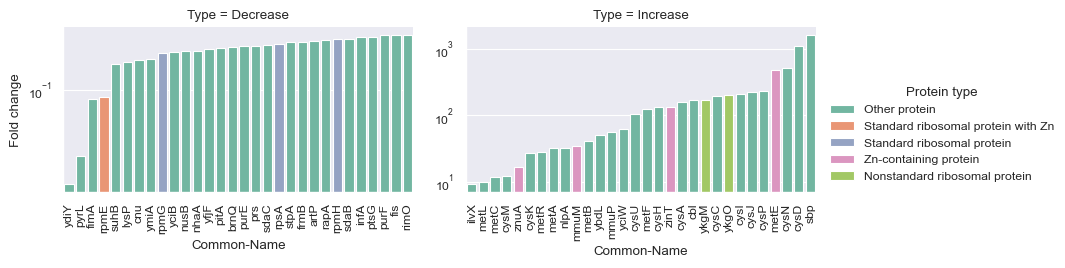

In [295]:
# create dataframe with the counts
li_df = pl.DataFrame([li_counts, li_counts_met, monomer_ids, zn_protein_mask, ribosome_protein_mask, nonstandard_ribosome_protein_mask], 
                     schema=["Complete", "Methionine", "Protein ID", "Uses Zn", "Ribosomal protein", "Nonstandard ribosomal protein"])

# create new conditional column. If both Uses Zn and Ribosomal protein are true, then "Ribosomal protein with Zn"
li_df = li_df.with_columns(pl.lit("N/A").alias("Protein type"))

# iterate over rows
for i in range(li_df.shape[0]):
    if li_df[i, "Uses Zn"] and li_df[i, "Ribosomal protein"]:
        li_df[i, "Protein type"] = "Standard ribosomal protein with Zn"
    elif li_df[i, "Uses Zn"]:
        li_df[i, "Protein type"] = "Zn-containing protein"
    elif li_df[i, "Ribosomal protein"]:
        li_df[i, "Protein type"] = "Standard ribosomal protein"
    elif li_df[i, "Nonstandard ribosomal protein"]:
        li_df[i, "Protein type"] = "Nonstandard ribosomal protein"
    else:
        li_df[i, "Protein type"] = "Other protein"


# join with name df to get common names
li_df = li_df.join(name_df, left_on="Protein ID", right_on="Proteins")

# drop rows where both complete and methionine are <1000
li_df = li_df.filter((pl.col("Complete") > 1000) | (pl.col("Methionine") > 1000))
# li_df = li_df.filter((pl.col("Complete") > 200) & (pl.col("Methionine") > 200))


reg = 10
# calculate fold change from complete to methionine
li_df = li_df.with_columns( ((li_df["Methionine"] + reg) / (li_df["Complete"] + reg)).alias("Fold change"))

# sort by fold change
li_df = li_df.sort("Fold change", descending=False)

# make new df with just head and tail
n = 30
li_df_head = li_df.head(n).with_columns(pl.lit("Decrease").alias("Type"))
li_df_tail = li_df.tail(n).with_columns(pl.lit("Increase").alias("Type"))
# concat
li_df_short = pl.concat([li_df_head, li_df_tail])


# plot log fold change against protein id
g = sns.catplot(data=li_df_short.to_pandas(), x="Common-Name", hue="Protein type", dodge=False,
                y="Fold change", kind="bar", aspect=1.7, height=2.5, col="Type", sharex=False, sharey=False, log=True)

# rotate labels
g.set_xticklabels(rotation=90)

## Growth rate data

In [327]:
gr = pl.read_csv("data/growth_rate_processed.csv")

# rename slope to Growth rate
gr = gr.rename({"slope": "Growth rate (1/hr)", "doubling_time": "Doubling time (h)", "doubling_time_min": "Doubling time (min)"})

# Only keep columns Additive, Replicate, Growth rate
gr = gr.select("Additive", "Growth rate (1/hr)")

gr.head()

Additive,Growth rate (1/hr)
str,f64
"""B12""",1.118869
"""B12""",1.060833
"""B12""",1.102755
"""Zn""",1.068039
"""Zn""",1.102385


In [328]:
# get mean of growth rate for met
met_mean = gr.filter(pl.col("Additive") == "met").mean().select("Growth rate (1/hr)")

# add a column with met_mean as the value
gr = gr.with_columns(pl.lit(met_mean).alias("Mean growth rate (1/hr)"))

# calculate growth rate decrease from mean
gr = gr.with_columns( ((gr["Growth rate (1/hr)"] / gr["Mean growth rate (1/hr)"])).alias("Growth rate defect"))

(0.8, 1.05)

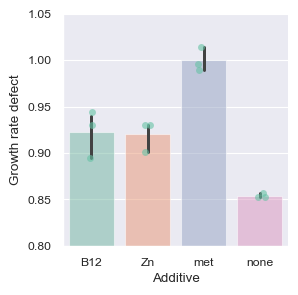

In [341]:

g = sns.catplot(data=gr.to_pandas(), x="Additive", y="Growth rate defect", kind="bar", aspect=1, height=3, alpha=0.5)

g.map_dataframe(sns.stripplot, x="Additive", y="Growth rate defect", alpha=0.6, dodge=True, jitter=0.1, size=5)

plt.ylim(0.8, 1.05)

    # Timeseries stability of aggregate molecules

In [ ]:
elements = ["ZN"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_vec = C @ P @ E[:, element_indices]

# multiply rows of total_counts by element_vec
total_counts_zn = total_counts.copy()

for i in range(total_counts_zn.shape[0]):
    total_counts_zn[i, :] = np.multiply(total_counts_zn[i, :], element_vec.toarray().flatten())
    
# eliminate columns with all zeros
filter_cols = np.any(total_counts_zn, axis=0)
total_counts_zn_filter = total_counts_zn[:, filter_cols]

# index protein ids by filter_cols
protein_ids_filter = protein_ids[filter_cols]

In [ ]:
# create a dataframe with the timeseries
total_counts_zn_df = pl.DataFrame(total_counts_zn_filter, schema=protein_ids_filter.tolist())

# add timestep column
total_counts_zn_df = total_counts_zn_df.with_columns(pl.DataFrame(np.arange(0, total_counts_zn_df.shape[0]), schema=["Timestep"]))

# melt to long form
total_counts_zn_df_m = total_counts_zn_df.melt(value_name="Atoms/cell", variable_name="Protein ID", id_vars="Timestep")

# for each protein, find value with timestep 0
initial_values = total_counts_zn_df_m.filter(pl.col("Timestep") == 0)

# alias the column to avoid confusion
initial_values = initial_values.with_columns(pl.col("Atoms/cell").alias("Initial Atoms/cell"))

# join with the original dataframe
total_counts_zn_df_m = total_counts_zn_df_m.join(initial_values, on="Protein ID", how="left")

# filter out proteins with initial atoms/cell less than 100
total_counts_zn_df_m = total_counts_zn_df_m.filter(pl.col("Initial Atoms/cell") > 20)

# calculate the fold change
total_counts_zn_df_m = total_counts_zn_df_m.with_columns( ((total_counts_zn_df_m["Atoms/cell"] +0)/ (total_counts_zn_df_m["Initial Atoms/cell"] +0)).alias("Fold change since t=0"))

# create a sum_df from total_counts_zn_df
sum_df = total_counts_zn_df_m.group_by("Timestep").agg(pl.sum("Atoms/cell").alias("Total atoms"))

# divide sum_df Total atoms by the initial value
sum_df = sum_df.with_columns( (sum_df["Total atoms"] / sum_df.filter(pl.col("Timestep") == 0)["Total atoms"][0]).alias("Fold change since t=0"))

In [ ]:
# plot timeseries for all proteins in a single big chart
sns.lineplot(data=total_counts_zn_df_m.to_pandas(), x="Timestep", y="Fold change since t=0", hue="Protein ID", legend=False, alpha=0.1, palette="gray")


# plot the sum as a thicker line
sns.lineplot(data=sum_df.to_pandas(), x="Timestep", y="Fold change since t=0", color="black", linewidth=2, label="Total Zn atoms/cell")

In [ ]:
uptake_df = sum_df.sort(by="Timestep")

# per timestep, calculate the difference from the previous timestep in atoms/cell
uptake_df = uptake_df.with_columns( (uptake_df["Total atoms"] - uptake_df["Total atoms"].shift(1)).alias("Current uptake"))

# do a 5 row moving average of the current uptake
uptake_df = uptake_df.with_columns( (uptake_df["Current uptake"].rolling_mean(window_size=10)).alias("Moving average (10s)"))

# drop rows with null values in current uptake
uptake_df = uptake_df.filter(pl.col("Moving average (10s)").is_not_null())


# plot current uptake
sns.lineplot(data=uptake_df.to_pandas(), x="Timestep", y="Current uptake", color="black", linewidth=0.5, alpha=0.1, label="Uptake per timestep")
sns.lineplot(data=uptake_df.to_pandas(), x="Timestep", y="Moving average (10s)", color="black", linewidth=1, label="10s moving average uptake")

plt.ylim(0, None)

In [ ]:
total_counts_zn_df

# select columns with a minimum larger than 100
total_counts_zn_df_s = total_counts_zn_df.select(pl.all().min() > 500)
include = {k: v[0] for k,v in total_counts_zn_df_s.to_dict(as_series=False).items()}
include = [k for k,v in include.items() if v][0:10]

# select columns where total_counts_zn_df_pruned is true
total_counts_zn_df_pruned = total_counts_zn_df.select(include)

# calculate the difference from previous step
diff_df = total_counts_zn_df_pruned.with_columns( (total_counts_zn_df_pruned - total_counts_zn_df_pruned.shift(1)))
                                     
# melt
diff_df = diff_df.with_columns(pl.DataFrame(np.arange(0, diff_df.shape[0]), schema=["Timestep"]))

diff_df = diff_df.melt(value_name="Uptake per protein", variable_name="Protein ID", id_vars="Timestep")
diff_df = diff_df.with_columns( (diff_df["Uptake per protein"].rolling_mean(window_size=20)).alias("Moving average (10s)"))

diff_df                                                                         

In [ ]:
plt.figure(figsize=(10, 6))

# sns.lineplot(data=diff_df.to_pandas(), x="Timestep", y="Uptake per protein", hue="Protein ID", legend=False, alpha=1, linewidth=2, palette="gray")
sns.lineplot(data=diff_df.to_pandas(), x="Timestep", y="Moving average (10s)", hue="Protein ID", legend=False, alpha=1, linewidth=1, palette="viridis")


## Transporter mean and noise

In [ ]:
transporter_IDs = ['ABC-63-CPLX', 'ZNUC-MONOMER', 'YHHO-MONOMER', 'B0752-MONOMER', 'EG11167-MONOMER']

# find the indices of the transporters
ts_idx = [np.where(protein_ids == transporter)[0][0] for transporter in transporter_IDs]


# make df
ts_df = pl.DataFrame(total_counts_min[:, ts_idx], schema=transporter_IDs)

# plot timeseries
plt.figure(figsize=(10, 6))
sns.lineplot(data=ts_df.to_pandas(), dashes=False, linewidth=1)

In [ ]:
ts_df.std()

In [ ]:
total_counts_zn_df

# select columns with a minimum larger than 100
total_counts_zn_df_s = total_counts_zn_df.select(pl.all().min() > 500)
include = {k: v[0] for k,v in total_counts_zn_df_s.to_dict(as_series=False).items()}
include = [k for k,v in include.items() if v][0:10]

# select columns where total_counts_zn_df_pruned is true
total_counts_zn_df_pruned = total_counts_zn_df.select(include)

# calculate the difference from previous step
diff_df = total_counts_zn_df_pruned.with_columns( (total_counts_zn_df_pruned - total_counts_zn_df_pruned.shift(1)))
                                     
# melt
diff_df = diff_df.with_columns(pl.DataFrame(np.arange(0, diff_df.shape[0]), schema=["Timestep"]))

diff_df = diff_df.melt(value_name="Uptake per protein", variable_name="Protein ID", id_vars="Timestep")
diff_df = diff_df.with_columns( (diff_df["Uptake per protein"].rolling_mean(window_size=20)).alias("Moving average (10s)"))

diff_df                                                                         

In [ ]:
plt.figure(figsize=(10, 6))

# sns.lineplot(data=diff_df.to_pandas(), x="Timestep", y="Uptake per protein", hue="Protein ID", legend=False, alpha=1, linewidth=2, palette="gray")
sns.lineplot(data=diff_df.to_pandas(), x="Timestep", y="Moving average (10s)", hue="Protein ID", legend=False, alpha=1, linewidth=1, palette="viridis")
